<a href="https://colab.research.google.com/github/Bright-Momo/SimplifiedJournalsGame/blob/main/Strategy_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running 500 simulations for each error rate...
This may take a few minutes...

Processing error rate ε = λ = 0.1
  Completed 100/500 simulations
  Completed 200/500 simulations
  Completed 300/500 simulations
  Completed 400/500 simulations
  Completed 500/500 simulations

Processing error rate ε = λ = 0.3
  Completed 100/500 simulations
  Completed 200/500 simulations
  Completed 300/500 simulations
  Completed 400/500 simulations
  Completed 500/500 simulations

Processing error rate ε = λ = 0.5
  Completed 100/500 simulations
  Completed 200/500 simulations
  Completed 300/500 simulations
  Completed 400/500 simulations
  Completed 500/500 simulations

Processing error rate ε = λ = 0.7
  Completed 100/500 simulations
  Completed 200/500 simulations
  Completed 300/500 simulations
  Completed 400/500 simulations
  Completed 500/500 simulations

Processing error rate ε = λ = 0.9
  Completed 100/500 simulations
  Completed 200/500 simulations
  Completed 300/500 simulations
  Completed

<ipython-input-2-bf6283a408c2>:397: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


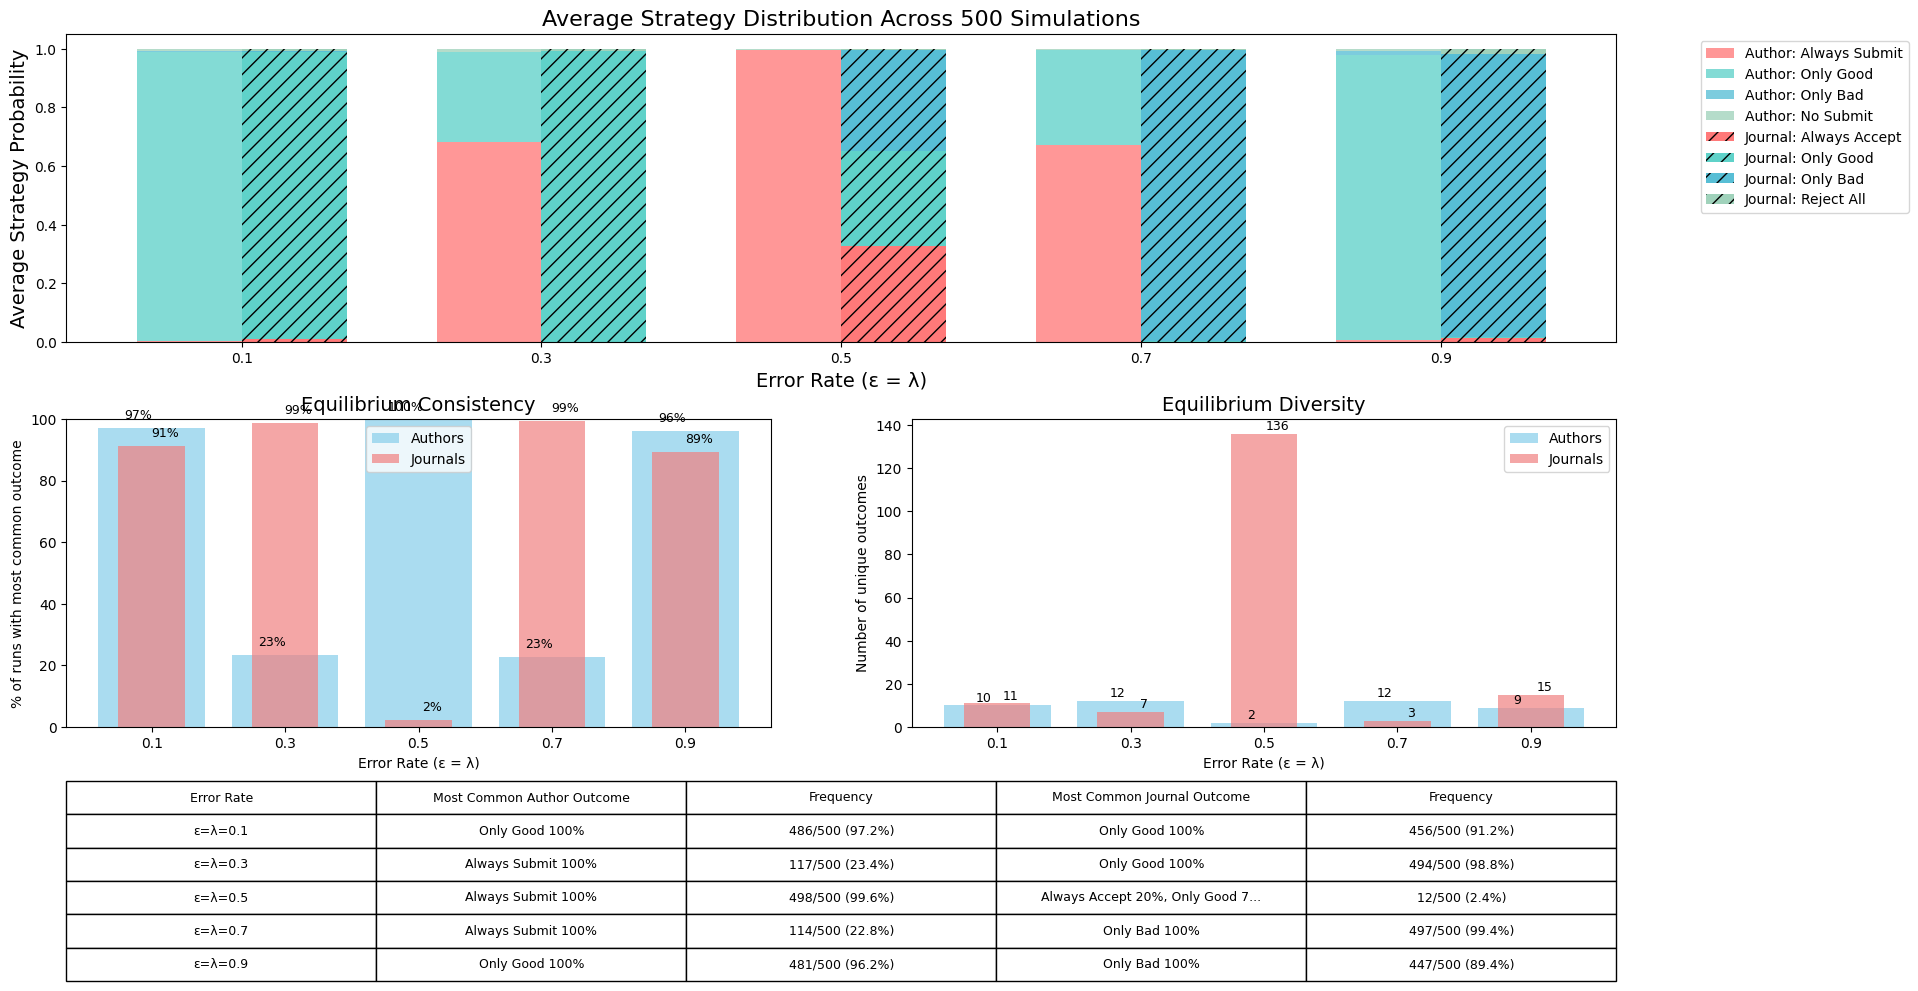

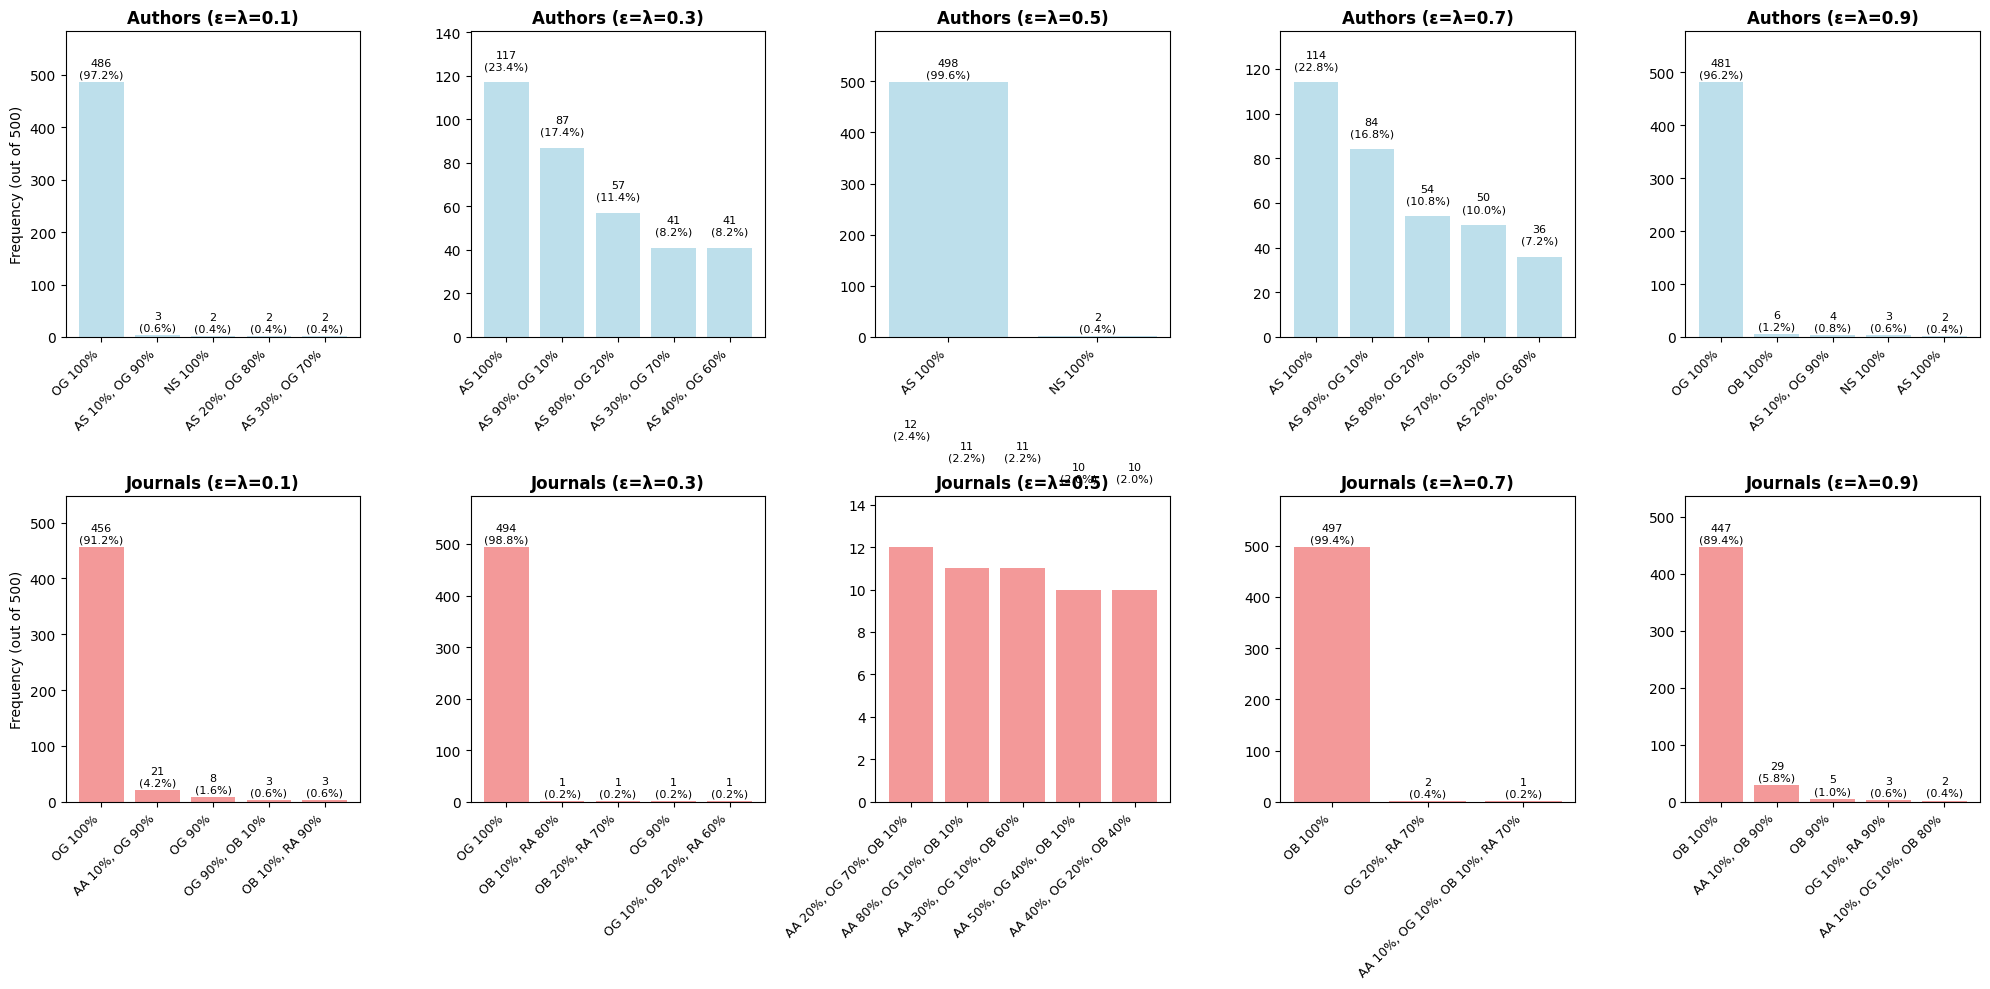

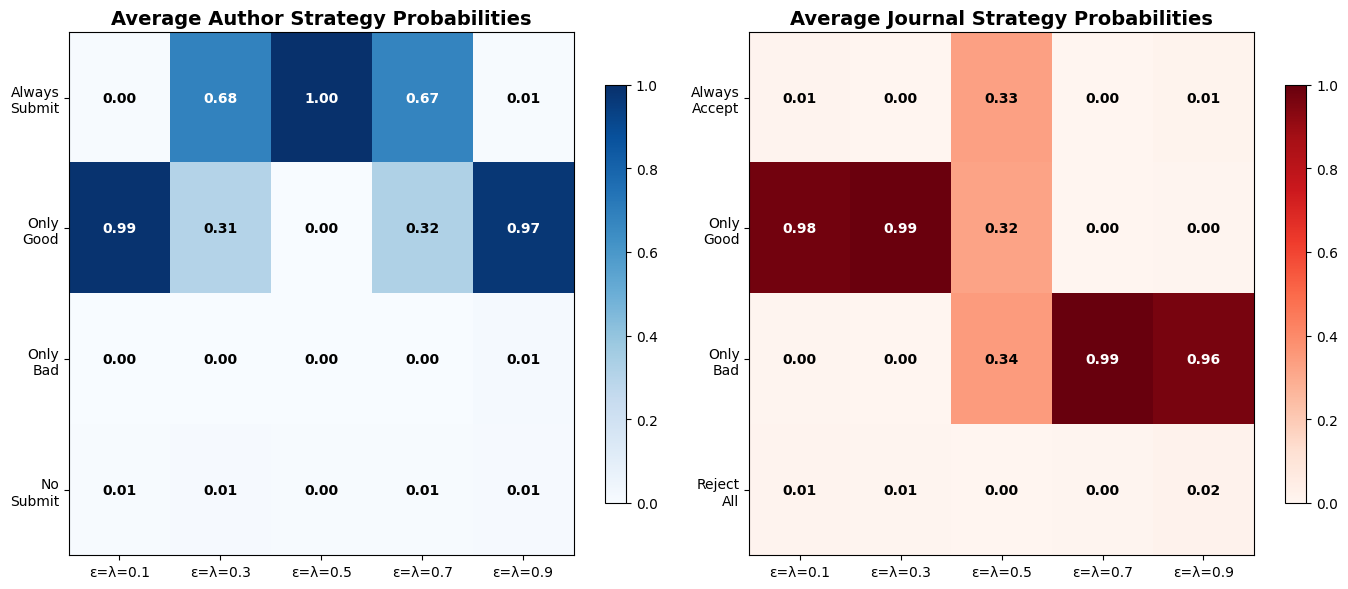


FINAL SUMMARY

Error Rate ε = λ = 0.1:
  Most common author outcome: Only Good 100% (486/500 = 97.2%)
  Most common journal outcome: Only Good 100% (456/500 = 91.2%)
  Number of unique author outcomes: 10
  Number of unique journal outcomes: 11

Error Rate ε = λ = 0.3:
  Most common author outcome: Always Submit 100% (117/500 = 23.4%)
  Most common journal outcome: Only Good 100% (494/500 = 98.8%)
  Number of unique author outcomes: 12
  Number of unique journal outcomes: 7

Error Rate ε = λ = 0.5:
  Most common author outcome: Always Submit 100% (498/500 = 99.6%)
  Most common journal outcome: Always Accept 20%, Only Good 70%, Only Bad 10% (12/500 = 2.4%)
  Number of unique author outcomes: 2
  Number of unique journal outcomes: 136

Error Rate ε = λ = 0.7:
  Most common author outcome: Always Submit 100% (114/500 = 22.8%)
  Most common journal outcome: Only Bad 100% (497/500 = 99.4%)
  Number of unique author outcomes: 12
  Number of unique journal outcomes: 3

Error Rate ε = λ = 0.

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from collections import defaultdict
import json

# Parameters (constant)
alpha = 0.6    # Probability of a good paper
r = 1.0        # Reward for author when accepted
c = 0.5        # Cost for author when rejected
gamma = 0.1    # Cost for journal when reviewing a paper

def acceptance_probability(is_good_paper, journal_strategy, epsilon, lam):
    if journal_strategy == 0:  # Always Accept
        return 1.0
    elif journal_strategy == 1:  # Only Accept Good
        return 1 - epsilon if is_good_paper else lam
    elif journal_strategy == 2:  # Only Accept Bad
        return epsilon if is_good_paper else 1 - lam
    else:  # Reject All
        return 0.0

def author_journal_payoff(author_strategy, journal_strategy, epsilon, lam):
    if author_strategy == 0:
        good_prob, bad_prob = alpha, 1 - alpha
    elif author_strategy == 1:
        good_prob, bad_prob = alpha, 0
    elif author_strategy == 2:
        good_prob, bad_prob = 0, 1 - alpha
    else:
        good_prob, bad_prob = 0, 0

    p_accept_good = acceptance_probability(True, journal_strategy, epsilon, lam)
    p_accept_bad = acceptance_probability(False, journal_strategy, epsilon, lam)

    accept_rate = good_prob * p_accept_good + bad_prob * p_accept_bad
    submit_rate = good_prob + bad_prob
    reject_rate = submit_rate - accept_rate

    author_payoff = accept_rate * r - reject_rate * c

    # Payoff equation
    if accept_rate > 0:
        journal_payoff = (good_prob * p_accept_good) / accept_rate - gamma * submit_rate
    else:
        journal_payoff = 0  # pay nothing if no receive paper

    return author_payoff, journal_payoff

def build_payoff_matrices(epsilon, lam):
    num_strategies = 4

    # Initialize payoff matrices
    author_payoff_matrix = np.zeros((num_strategies, num_strategies))
    journal_payoff_matrix = np.zeros((num_strategies, num_strategies))

    # Calculate payoffs for all strategy combinations
    for i in range(num_strategies):
        for j in range(num_strategies):
            author_pay, journal_pay = author_journal_payoff(i, j, epsilon, lam)
            author_payoff_matrix[i, j] = author_pay
            journal_payoff_matrix[i, j] = journal_pay

    return author_payoff_matrix, journal_payoff_matrix

def replicator_dynamics(y, t, author_matrix, journal_matrix):
    # Strategy frequencies
    author_freqs = y[:4]
    journal_freqs = y[4:]

    # Frequencies are valid
    author_freqs = np.clip(author_freqs, 0, 1)
    journal_freqs = np.clip(journal_freqs, 0, 1)

    # Sum equals 1
    author_freqs = author_freqs / np.sum(author_freqs)
    journal_freqs = journal_freqs / np.sum(journal_freqs)

    # Expected payoffs for each strategy
    author_expected_payoffs = np.dot(author_matrix, journal_freqs)
    journal_expected_payoffs = np.dot(author_freqs, journal_matrix)

    # Average payoffs
    avg_author_payoff = np.dot(author_freqs, author_expected_payoffs)
    avg_journal_payoff = np.dot(journal_freqs, journal_expected_payoffs)

    # Replicator equation
    author_derivs = author_freqs * (author_expected_payoffs - avg_author_payoff)
    journal_derivs = journal_freqs * (journal_expected_payoffs - avg_journal_payoff)

    # Combine derivatives and return
    return np.concatenate([author_derivs, journal_derivs])

def run_single_simulation(epsilon, lam, time_points):
    """Run a single simulation with random initial conditions"""
    # Build payoff matrices
    author_matrix, journal_matrix = build_payoff_matrices(epsilon, lam)

    # Generate random initial strategy frequencies using Dirichlet distribution
    author_initial = np.random.dirichlet(np.ones(4))
    journal_initial = np.random.dirichlet(np.ones(4))

    # Combine into initial state vector
    initial_freqs = np.concatenate([author_initial, journal_initial])

    # Solve dynamics
    solution = odeint(replicator_dynamics, initial_freqs, time_points, args=(author_matrix, journal_matrix))

    # Get final state
    author_final = solution[-1, :4]
    journal_final = solution[-1, 4:]

    # Normalize
    author_final = author_final / np.sum(author_final)
    journal_final = journal_final / np.sum(journal_final)

    return author_final, journal_final

def create_strategy_key(strategy_vector, strategy_names):
    """Create a dictionary key based on strategy probabilities"""
    # Round to nearest 10% and create key
    rounded_probs = np.round(strategy_vector * 10) * 10  # Round to nearest 10%

    # Create key string
    key_parts = []
    for i, prob in enumerate(rounded_probs.astype(int)):
        if prob > 0:
            key_parts.append(f"{strategy_names[i]} {prob}%")

    if not key_parts:
        key_parts = ["All strategies 0%"]

    return ", ".join(key_parts)

def initialize_results_dict():
    """Initialize the results dictionary with all possible combinations"""
    results = {
        'author': defaultdict(int),
        'journal': defaultdict(int)
    }
    return results

# Strategy names
author_names = ["Always Submit", "Only Good", "Only Bad", "No Submit"]
journal_names = ["Always Accept", "Only Good", "Only Bad", "Reject All"]

# Selected error rates to analyze
error_rates = [0.1, 0.3, 0.5, 0.7, 0.9]

# Number of simulations to run
num_simulations = 500

# Time points for simulation
t = np.arange(0, 100.1, 0.1)

# Main analysis
all_results = {}

print("Running 500 simulations for each error rate...")
print("This may take a few minutes...")

for error_rate in error_rates:
    print(f"\nProcessing error rate ε = λ = {error_rate}")

    # Initialize results dictionary for this error rate
    results = initialize_results_dict()

    # Store raw results for additional analysis
    raw_author_results = []
    raw_journal_results = []

    # Run simulations
    for sim in range(num_simulations):
        if (sim + 1) % 100 == 0:
            print(f"  Completed {sim + 1}/{num_simulations} simulations")

        # Run single simulation
        author_final, journal_final = run_single_simulation(error_rate, error_rate, t)

        # Store raw results
        raw_author_results.append(author_final)
        raw_journal_results.append(journal_final)

        # Create keys and update counters
        author_key = create_strategy_key(author_final, author_names)
        journal_key = create_strategy_key(journal_final, journal_names)

        results['author'][author_key] += 1
        results['journal'][journal_key] += 1

    # Store results for this error rate
    all_results[error_rate] = {
        'counts': results,
        'raw_author': np.array(raw_author_results),
        'raw_journal': np.array(raw_journal_results)
    }

# Print detailed results
print("\n" + "="*80)
print("DETAILED RESULTS FOR ALL ERROR RATES")
print("="*80)

for error_rate in error_rates:
    print(f"\nError Rate ε = λ = {error_rate}")
    print("-" * 50)

    author_results = all_results[error_rate]['counts']['author']
    journal_results = all_results[error_rate]['counts']['journal']

    print("AUTHOR STRATEGIES:")
    # Sort by frequency (most common first)
    sorted_author = sorted(author_results.items(), key=lambda x: x[1], reverse=True)
    for strategy_combination, count in sorted_author:
        percentage = (count / num_simulations) * 100
        print(f"  {strategy_combination}: {count} times ({percentage:.1f}%)")

    print("\nJOURNAL STRATEGIES:")
    sorted_journal = sorted(journal_results.items(), key=lambda x: x[1], reverse=True)
    for strategy_combination, count in sorted_journal:
        percentage = (count / num_simulations) * 100
        print(f"  {strategy_combination}: {count} times ({percentage:.1f}%)")

    # Calculate statistics
    raw_author = all_results[error_rate]['raw_author']
    raw_journal = all_results[error_rate]['raw_journal']

    print(f"\nSTATISTICAL SUMMARY:")
    print(f"Author strategy means: {np.mean(raw_author, axis=0)}")
    print(f"Author strategy std: {np.std(raw_author, axis=0)}")
    print(f"Journal strategy means: {np.mean(raw_journal, axis=0)}")
    print(f"Journal strategy std: {np.std(raw_journal, axis=0)}")

# Create better visualization - Summary Table Format
def create_summary_table():
    """Create a summary table showing the most common outcomes for each error rate"""
    summary_data = {}

    for error_rate in error_rates:
        author_results = all_results[error_rate]['counts']['author']
        journal_results = all_results[error_rate]['counts']['journal']

        # Get top 3 most common outcomes for each
        top_author = sorted(author_results.items(), key=lambda x: x[1], reverse=True)[:3]
        top_journal = sorted(journal_results.items(), key=lambda x: x[1], reverse=True)[:3]

        summary_data[error_rate] = {
            'author_top3': top_author,
            'journal_top3': top_journal,
            'author_diversity': len(author_results),
            'journal_diversity': len(journal_results)
        }

    return summary_data

# Create improved visualization
fig = plt.figure(figsize=(20, 12))

# Create a grid layout
gs = fig.add_gridspec(3, 2, height_ratios=[2, 2, 1], hspace=0.3, wspace=0.2)

# Top panel: Dominant strategy distribution
ax1 = fig.add_subplot(gs[0, :])

# Prepare data for stacked bar chart
author_dominant_probs = np.zeros((len(error_rates), 4))  # 4 strategies
journal_dominant_probs = np.zeros((len(error_rates), 4))

for i, error_rate in enumerate(error_rates):
    raw_author = all_results[error_rate]['raw_author']
    raw_journal = all_results[error_rate]['raw_journal']

    # Calculate mean probabilities for each strategy
    author_dominant_probs[i] = np.mean(raw_author, axis=0)
    journal_dominant_probs[i] = np.mean(raw_journal, axis=0)

# Create grouped bar chart
x = np.arange(len(error_rates))
width = 0.35

# Plot author strategies
bottom_author = np.zeros(len(error_rates))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for j in range(4):
    ax1.bar(x - width/2, author_dominant_probs[:, j], width,
            bottom=bottom_author, label=f'Author: {author_names[j]}',
            color=colors[j], alpha=0.7)
    bottom_author += author_dominant_probs[:, j]

# Plot journal strategies
bottom_journal = np.zeros(len(error_rates))
for j in range(4):
    ax1.bar(x + width/2, journal_dominant_probs[:, j], width,
            bottom=bottom_journal, label=f'Journal: {journal_names[j]}',
            color=colors[j], alpha=0.9, hatch='//')
    bottom_journal += journal_dominant_probs[:, j]

ax1.set_xlabel('Error Rate (ε = λ)', fontsize=14)
ax1.set_ylabel('Average Strategy Probability', fontsize=14)
ax1.set_title('Average Strategy Distribution Across 500 Simulations', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels([f'{rate}' for rate in error_rates])
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Middle panel: Consistency analysis
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Calculate and plot consistency metrics
author_consistency = []
journal_consistency = []
author_diversity = []
journal_diversity = []

for error_rate in error_rates:
    author_results = all_results[error_rate]['counts']['author']
    journal_results = all_results[error_rate]['counts']['journal']

    # Most common outcome frequency
    most_common_author = max(author_results.values())
    most_common_journal = max(journal_results.values())

    author_consistency.append(most_common_author / num_simulations * 100)
    journal_consistency.append(most_common_journal / num_simulations * 100)

    # Diversity (number of unique outcomes)
    author_diversity.append(len(author_results))
    journal_diversity.append(len(journal_results))

# Consistency plot
ax2.bar(range(len(error_rates)), author_consistency, color='skyblue', alpha=0.7, label='Authors')
ax2.bar(range(len(error_rates)), journal_consistency, color='lightcoral', alpha=0.7, label='Journals', width=0.5)
ax2.set_title('Equilibrium Consistency', fontsize=14)
ax2.set_ylabel('% of runs with most common outcome')
ax2.set_xlabel('Error Rate (ε = λ)')
ax2.set_xticks(range(len(error_rates)))
ax2.set_xticklabels([f'{rate}' for rate in error_rates])
ax2.legend()
ax2.set_ylim(0, 100)

# Add percentage labels
for i, (a_cons, j_cons) in enumerate(zip(author_consistency, journal_consistency)):
    ax2.text(i-0.1, a_cons + 2, f'{a_cons:.0f}%', ha='center', va='bottom', fontsize=9)
    ax2.text(i+0.1, j_cons + 2, f'{j_cons:.0f}%', ha='center', va='bottom', fontsize=9)

# Diversity plot
ax3.bar(range(len(error_rates)), author_diversity, color='skyblue', alpha=0.7, label='Authors')
ax3.bar(range(len(error_rates)), journal_diversity, color='lightcoral', alpha=0.7, label='Journals', width=0.5)
ax3.set_title('Equilibrium Diversity', fontsize=14)
ax3.set_ylabel('Number of unique outcomes')
ax3.set_xlabel('Error Rate (ε = λ)')
ax3.set_xticks(range(len(error_rates)))
ax3.set_xticklabels([f'{rate}' for rate in error_rates])
ax3.legend()

# Add count labels
for i, (a_div, j_div) in enumerate(zip(author_diversity, journal_diversity)):
    ax3.text(i-0.1, a_div + 0.5, f'{a_div}', ha='center', va='bottom', fontsize=9)
    ax3.text(i+0.1, j_div + 0.5, f'{j_div}', ha='center', va='bottom', fontsize=9)

# Bottom panel: Detailed results table
ax4 = fig.add_subplot(gs[2, :])
ax4.axis('tight')
ax4.axis('off')

# Create table data
table_data = []
headers = ['Error Rate', 'Most Common Author Outcome', 'Frequency', 'Most Common Journal Outcome', 'Frequency']

for error_rate in error_rates:
    author_results = all_results[error_rate]['counts']['author']
    journal_results = all_results[error_rate]['counts']['journal']

    # Most common outcomes
    most_common_author = max(author_results, key=author_results.get)
    most_common_journal = max(journal_results, key=journal_results.get)

    author_freq = author_results[most_common_author]
    journal_freq = journal_results[most_common_journal]

    # Truncate long strategy names for table
    author_short = most_common_author[:30] + "..." if len(most_common_author) > 30 else most_common_author
    journal_short = most_common_journal[:30] + "..." if len(most_common_journal) > 30 else most_common_journal

    table_data.append([
        f'ε=λ={error_rate}',
        author_short,
        f'{author_freq}/500 ({author_freq/500*100:.1f}%)',
        journal_short,
        f'{journal_freq}/500 ({journal_freq/500*100:.1f}%)'
    ])

table = ax4.table(cellText=table_data, colLabels=headers, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

plt.tight_layout()
plt.show()

# Create additional detailed analysis plots
def create_detailed_outcome_analysis():
    """Create focused plots showing the most common outcomes for each error rate"""

    fig, axes = plt.subplots(2, len(error_rates), figsize=(4*len(error_rates), 10))

    for i, error_rate in enumerate(error_rates):
        # Author outcomes
        ax_author = axes[0, i]
        author_results = all_results[error_rate]['counts']['author']

        # Get top 5 outcomes
        top_author = sorted(author_results.items(), key=lambda x: x[1], reverse=True)[:5]

        strategies = []
        counts = []
        for outcome, count in top_author:
            # Simplify strategy names for better readability
            simplified = outcome.replace("Always Submit", "AS").replace("Only Good", "OG").replace("Only Bad", "OB").replace("No Submit", "NS")
            strategies.append(simplified)
            counts.append(count)

        bars = ax_author.bar(range(len(strategies)), counts, color='lightblue', alpha=0.8)
        ax_author.set_title(f'Authors (ε=λ={error_rate})', fontsize=12, fontweight='bold')
        ax_author.set_ylabel('Frequency (out of 500)' if i == 0 else '', fontsize=10)
        ax_author.set_xticks(range(len(strategies)))
        ax_author.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)

        # Add percentage labels on bars
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            percentage = (count / num_simulations) * 100
            ax_author.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=8)

        ax_author.set_ylim(0, max(counts) * 1.2)

        # Journal outcomes
        ax_journal = axes[1, i]
        journal_results = all_results[error_rate]['counts']['journal']

        # Get top 5 outcomes
        top_journal = sorted(journal_results.items(), key=lambda x: x[1], reverse=True)[:5]

        strategies = []
        counts = []
        for outcome, count in top_journal:
            # Simplify strategy names for better readability
            simplified = outcome.replace("Always Accept", "AA").replace("Only Good", "OG").replace("Only Bad", "OB").replace("Reject All", "RA")
            strategies.append(simplified)
            counts.append(count)

        bars = ax_journal.bar(range(len(strategies)), counts, color='lightcoral', alpha=0.8)
        ax_journal.set_title(f'Journals (ε=λ={error_rate})', fontsize=12, fontweight='bold')
        ax_journal.set_ylabel('Frequency (out of 500)' if i == 0 else '', fontsize=10)
        ax_journal.set_xticks(range(len(strategies)))
        ax_journal.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)

        # Add percentage labels on bars
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            percentage = (count / num_simulations) * 100
            ax_journal.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=8)

        ax_journal.set_ylim(0, max(counts) * 1.2)

    plt.tight_layout()
    plt.show()

# Create the detailed analysis
create_detailed_outcome_analysis()

# Create a heatmap showing strategy probability distributions
def create_strategy_heatmap():
    """Create heatmaps showing average strategy probabilities"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Prepare data
    author_data = np.zeros((4, len(error_rates)))  # 4 strategies x 5 error rates
    journal_data = np.zeros((4, len(error_rates)))

    for i, error_rate in enumerate(error_rates):
        raw_author = all_results[error_rate]['raw_author']
        raw_journal = all_results[error_rate]['raw_journal']

        author_data[:, i] = np.mean(raw_author, axis=0)
        journal_data[:, i] = np.mean(raw_journal, axis=0)

    # Create heatmaps
    im1 = ax1.imshow(author_data, cmap='Blues', aspect='auto', vmin=0, vmax=1)
    ax1.set_title('Average Author Strategy Probabilities', fontsize=14, fontweight='bold')
    ax1.set_yticks(range(4))
    ax1.set_yticklabels([name.replace(" ", "\n") for name in author_names], fontsize=10)
    ax1.set_xticks(range(len(error_rates)))
    ax1.set_xticklabels([f'ε=λ={rate}' for rate in error_rates], fontsize=10)

    # Add text annotations
    for i in range(4):
        for j in range(len(error_rates)):
            text = ax1.text(j, i, f'{author_data[i, j]:.2f}',
                           ha="center", va="center", color="white" if author_data[i, j] > 0.5 else "black",
                           fontweight='bold')

    plt.colorbar(im1, ax=ax1, shrink=0.8)

    im2 = ax2.imshow(journal_data, cmap='Reds', aspect='auto', vmin=0, vmax=1)
    ax2.set_title('Average Journal Strategy Probabilities', fontsize=14, fontweight='bold')
    ax2.set_yticks(range(4))
    ax2.set_yticklabels([name.replace(" ", "\n") for name in journal_names], fontsize=10)
    ax2.set_xticks(range(len(error_rates)))
    ax2.set_xticklabels([f'ε=λ={rate}' for rate in error_rates], fontsize=10)

    # Add text annotations
    for i in range(4):
        for j in range(len(error_rates)):
            text = ax2.text(j, i, f'{journal_data[i, j]:.2f}',
                           ha="center", va="center", color="white" if journal_data[i, j] > 0.5 else "black",
                           fontweight='bold')

    plt.colorbar(im2, ax=ax2, shrink=0.8)

    plt.tight_layout()
    plt.show()

# Create the heatmap
create_strategy_heatmap()

# Save results to JSON for future analysis
output_data = {}
for error_rate in error_rates:
    output_data[str(error_rate)] = {
        'author_counts': dict(all_results[error_rate]['counts']['author']),
        'journal_counts': dict(all_results[error_rate]['counts']['journal'])
    }

# Print final summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

for error_rate in error_rates:
    author_results = all_results[error_rate]['counts']['author']
    journal_results = all_results[error_rate]['counts']['journal']

    # Most common outcomes
    most_common_author = max(author_results, key=author_results.get)
    most_common_journal = max(journal_results, key=journal_results.get)

    author_freq = author_results[most_common_author]
    journal_freq = journal_results[most_common_journal]

    print(f"\nError Rate ε = λ = {error_rate}:")
    print(f"  Most common author outcome: {most_common_author} ({author_freq}/{num_simulations} = {author_freq/num_simulations*100:.1f}%)")
    print(f"  Most common journal outcome: {most_common_journal} ({journal_freq}/{num_simulations} = {journal_freq/num_simulations*100:.1f}%)")
    print(f"  Number of unique author outcomes: {len(author_results)}")
    print(f"  Number of unique journal outcomes: {len(journal_results)}")

print(f"\nTotal simulations completed: {num_simulations * len(error_rates)}")